# Profit Curves

### Jack Bennetto
#### March 21, 2018

### Objectives

 * Explain why you would use a cost-benefit matrix and profit curve
 * Generate a profit curve and use it to make decisions

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Let's start with some (fake) data, with two features (one continuous, one integer) and a binary label.

In [50]:
npts = 10000
y = scs.bernoulli(0.2).rvs(npts)
X = pd.DataFrame({'a':scs.norm(0, 1).rvs(npts) + 0.3*y,
                  'b':scs.poisson(2*y + 2).rvs(npts)})

Let's make a graph!

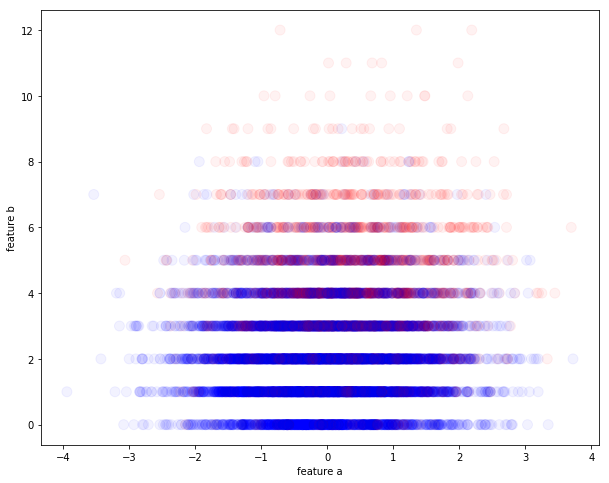

In [51]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(X.a, X.b, color=np.array(['b', 'r'])[y], alpha=0.05, s=100)
ax.set_xlabel('feature a')
ax.set_ylabel('feature b')

## Example: Fraud

To make this a little more realistic, let's imagine that you have a website to which people can sign up, and some small fraction of the signups are fraud. You're building a system to detect whether the account is fraudulent.

In [52]:
y = np.array(['Not', 'Fraud'])[y]

In [53]:
y

array(['Not', 'Not', 'Not', ..., 'Not', 'Not', 'Not'],
      dtype='<U5')

Now let's do a train-test split and fit a model. We'll do logistic regression, since that's all we know right now.

In [54]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
model = LogisticRegression()
model.fit(Xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Now we predict the results on the test set and see how often we are correct. For the moment we'll use the `predict` method, i.e., assume a 0.5 threshold, not because it's a good choice but just as a starting point.

In [55]:
model.predict(Xtest) == ytest

array([False,  True,  True, ...,  True,  True, False], dtype=bool)

In [56]:
(model.predict(Xtest) == ytest).mean()

0.81799999999999995

That's the accuracy.

Question: did we do a good job?

## An aside on class balance

We talked briefly about imbalanced classes earlier, situations where there are far more of one class than the other. Ordinarily this isn't an issue, but there are points that do require special consideration.

1. Hard classifiers are particularly problematic with imbalanced classes. They're a problem in general, but if you use a hard classifier it may predict everything to be in the majority class.
2. You should never use accuracy with imbalanced classes. You generally shouldn't use accuracy anyway, but again, it's easy to get a deceptively high accuracy by predicting everything is in the majority class.
3. You should be aware of situations when the class balance of the training data is different than that for which the model will be used in the real world.
4. The ability to predict or infer from your data is more a function of the size of the minority class than the size of all the data.
4. Some people believe other things, and some of them will be interviewing you. They may want you to talk about some of the ways to deal with them. There are a few techniques used to "balance" classes, including **undersampling**, **oversampling**, and **SMOTE**.

Oversampling my be appropriate when the training data doesn't match the actual data, but a class weight is generally better.

Undersampling may be appropriate in cases when you have more data than you can process; in these cases data in the majority class is less important to the result.

End of the aside.

Let's consider the full matrix of predicted and actual values.

In [67]:
model.predict(Xtest), ytest

(array(['Not', 'Not', 'Not', ..., 'Not', 'Not', 'Fraud'],
       dtype='<U5'), array(['Fraud', 'Not', 'Not', ..., 'Not', 'Not', 'Not'],
       dtype='<U5'))

In [68]:
predicted = model.predict(Xtest)
actual = ytest

In [69]:
pd.crosstab(ytest, model.predict(Xtest), rownames=['actual'], colnames=['predicted'])

predicted,Fraud,Not
actual,,
Fraud,148,384
Not,71,1897


This is interesting, except I want to be about to look at different thresholds. Here are a couple helper functions.

In [72]:
def predict(model, X, threshold=0.5):
    '''Return prediction of the fitted binary-classifier model model on X using threshold threshold.'''
    return np.where(model.predict_proba(X)[:, 1] > threshold,
                    model.classes_[1],
                    model.classes_[0])

def confusion_matrix(model, X, threshold=0.5):
    cf = pd.crosstab(ytest, predict(model, Xtest, threshold))
    cf = cf.add(pd.DataFrame([[0,0],[0,0]], columns=['Fraud', 'Not'], index=['Fraud', 'Not']), fill_value=0)
    cf.index.name = 'actual'
    cf.columns.name = 'predicted'
    return cf

In [73]:
confusion_matrix(model, X, 0.5)

predicted,Fraud,Not
actual,,
Fraud,148,384
Not,71,1897


Is that good?

Let's try a couple other thresholds. Which is best?

How do we decide the best value for a threshold?

In [74]:
confusion_matrix(model, X, 0.3)

predicted,Fraud,Not
actual,,
Fraud,66,466
Not,14,1954


In [75]:
confusion_matrix(model, X, 0.4)

predicted,Fraud,Not
actual,,
Fraud,100,432
Not,33,1935


In [76]:
confusion_matrix(model, X, 0.6)

predicted,Fraud,Not
actual,,
Fraud,210,322
Not,123,1845


In [77]:
confusion_matrix(model, X, 0.7)

predicted,Fraud,Not
actual,,
Fraud,283,249
Not,235,1733


## Making hard decisions

In the real world, bad predictions have actual costs, often in money but sometimes in some other metric (e.g., years of life).

In this case, let's assume that we might want to have a human investigate every account, but that's expensive so we're going to use our model. If the fitted model thinks it's fraud, we have a human investigate; if not we just approve it.

So there are four possibilities:

 * True positive: the account is fraudulent and we flag it for review.
 * True negative: the account is good and we create it automatically.
 * False positive: the account is good but we flag it, so a human has to do some unnecessary work checking the account.
 * False negative: the account is fraud but we let it through. Oops.

We that assign each of these a value, in dollars or whatever. Let's assume that it costs \$5 to review an account, a good account is worth \$10 to us, a fraudulent account costs us \$20, and reviews always catch fradulant accounts. So we can display all this in a cost-benefit matrix.

Questions: what are the values for the various cases?

In [82]:
cb_matrix = pd.DataFrame([[-5, -20], [5, 10]], columns=["Fraud", "Not"], index=["Fraud", "Not"])
cb_matrix.index.name = 'actual'
cb_matrix.columns.name = 'predicted'

In [83]:
cb_matrix

predicted,Fraud,Not
actual,,
Fraud,-5,-20
Not,5,10


Now we can just multiply stuff. For example, the total payout from the true positives is the number of true positives times the payout of each one.

In [84]:
confusion_matrix(model, X, 0.3) 

predicted,Fraud,Not
actual,,
Fraud,66,466
Not,14,1954


In [21]:
confusion_matrix(model, X, 0.3) * cb_matrix

predicted,Fraud,Not
actual,,
Fraud,-275,-8540
Not,80,20020


And the total payout is the sum of that.

In [22]:
(confusion_matrix(model, X, 0.3) * cb_matrix).values.sum()

11285

Let's look at that for a bunch of different values.

In [96]:
np.arange?

In [95]:
for threshold in np.arange(0.0, 1.01, 0.05):
    print("The payout for a threshold of {:3.2f} is ${:>5.0f}".
            format(threshold,
            (confusion_matrix(model, X, threshold) * cb_matrix).values.sum()))

The payout for a threshold of 0.00 is $ 9040
The payout for a threshold of 0.05 is $ 9115
The payout for a threshold of 0.10 is $ 9260
The payout for a threshold of 0.15 is $ 9410
The payout for a threshold of 0.20 is $ 9630
The payout for a threshold of 0.25 is $ 9745
The payout for a threshold of 0.30 is $ 9960
The payout for a threshold of 0.35 is $10180
The payout for a threshold of 0.40 is $10375
The payout for a threshold of 0.45 is $10590
The payout for a threshold of 0.50 is $10905
The payout for a threshold of 0.55 is $11225
The payout for a threshold of 0.60 is $11575
The payout for a threshold of 0.65 is $11975
The payout for a threshold of 0.70 is $12110
The payout for a threshold of 0.75 is $12235
The payout for a threshold of 0.80 is $12340
The payout for a threshold of 0.85 is $12025
The payout for a threshold of 0.90 is $11015
The payout for a threshold of 0.95 is $ 8740
The payout for a threshold of 1.00 is $ 7180


Question: what should we choose for a threshold?

## The profit curve

We have a bunch of numbers so we'll make a graph.



In [97]:
def calculate_payout(cb_matrix, model, X, threshold):
    return (confusion_matrix(model, X, threshold) * cb_matrix).values.sum()

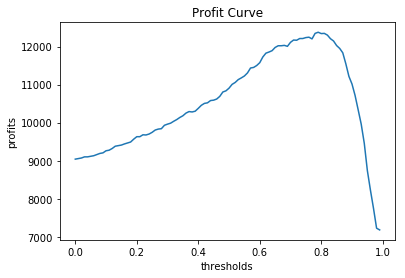

In [101]:
thresholds = np.arange(0.0, 1.0, 0.01)
profits = []
for threshold in thresholds:
    profits.append(calculate_payout(cb_matrix, model, X, threshold))

fig, ax = plt.subplots()
ax.plot(thresholds, profits)
ax.set_xlabel('thresholds')
ax.set_ylabel('profits')
ax.set_title('Profit Curve')

Question: What's going on at a threshold of 0?

Question: What's going on at a threshold of 1?

Question: Why is this jagged?

## Choosing a baseline

It's pretty common to get confused on cost or benefit of the different boxes. The important thing is to be consistant with the what counts as zero for each of the actual options.

Although there are four degrees of freedom in the cost-benefit matrix, really only two of them affect the shape of the profit curve, as we don't have control of the counts of the actual classes. Suppose, for example, in the old days every single account used to be checked. We might decide to have our profit matrix reflect how much our new approach we saves per user.

In [105]:
cb_matrix2 = cb_matrix + 5
cb_matrix2

predicted,Fraud,Not
actual,,
Fraud,0,-15
Not,10,15


Let's go back to the original cost-benefit matrix.

Question: what's the baseline in the case of Fraud? What's the baseline if in the case of Not-Fraud?

In [106]:
cb_matrix

predicted,Fraud,Not
actual,,
Fraud,-5,-20
Not,5,10


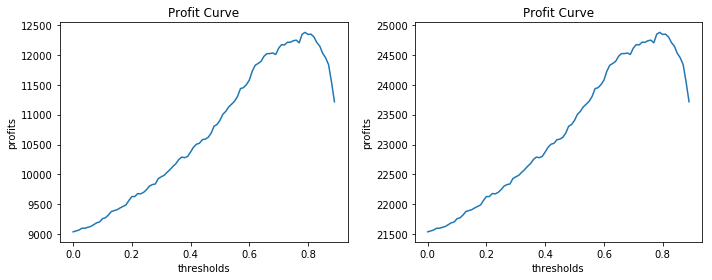

In [107]:
thresholds = np.arange(0.0, 0.9, 0.01)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, matrix in zip(axes, [cb_matrix, cb_matrix2]):
    profits = []
    for threshold in thresholds:
        profits.append(calculate_payout(matrix, model, X, threshold))
    ax.plot(thresholds, profits)
    ax.set_xlabel('thresholds')
    ax.set_ylabel('profits')
    ax.set_title('Profit Curve')
fig.tight_layout()

Question: what's the difference between these?

Or maybe originally we didn't check any of the accounts, but wrote off the cost of fraud cases, assuming they existed in some number and including them in the accounting. Then the cost-benefit matrix looks like this.

In [108]:
cb_matrix3 = cb_matrix.copy()
cb_matrix3.iloc[0] += 20
cb_matrix3

predicted,Fraud,Not
actual,,
Fraud,15,0
Not,5,10


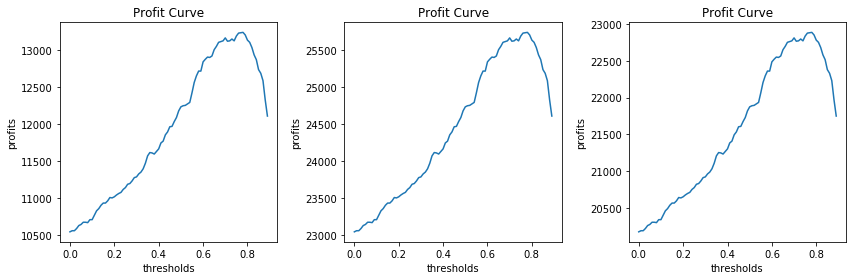

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, matrix in zip(axes, [cb_matrix, cb_matrix2, cb_matrix3]):
    profits = []
    for threshold in thresholds:
        profits.append(calculate_payout(matrix, model, X, threshold))
    ax.plot(thresholds, profits)
    ax.set_xlabel('thresholds')
    ax.set_ylabel('profits')
    ax.set_title('Profit Curve')
fig.tight_layout()

These three graphs have the same overall shape. What do these cost benefit matrices have in common?

Create another cost-benefit matrix for which the profit curve will have the same shape. 

In [114]:
IPython.display.display(cb_matrix)
IPython.display.display(cb_matrix2)
IPython.display.display(cb_matrix3)

predicted,Fraud,Not
actual,,
Fraud,-5,-20
Not,5,10


predicted,Fraud,Not
actual,,
Fraud,0,-15
Not,10,15


predicted,Fraud,Not
actual,,
Fraud,15,0
Not,5,10
